In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.dm import DataModule

dm = DataModule(batch_size=4)
dm.setup()

train: 8689
test: 2773


In [3]:
x, labels = next(iter(dm.train_dataloader()))

s1, s2 = x
s1.shape, s2.shape, s2.max(), s2.min()

(torch.Size([4, 12, 2, 256, 256]),
 torch.Size([4, 12, 3, 256, 256]),
 tensor(1.),
 tensor(0.))

In [4]:
from src.models.unet_attn import UNetA

hparams = {
    'encoder': 'resnet18',
    'pretrained': None,
    'in_channels_s1': 2,
    'in_channels_s2': 3,
    'seq_len': 12,
    'n_embed': 64,
    'n_heads': 1,
}

model = UNetA(hparams)

In [5]:
outputs = model(x)

outputs.shape

torch.Size([4, 256, 256])

In [7]:
import pytorch_lightning as pl

dm = DataModule(batch_size=4)

hparams = {
	'encoder': 'resnet18',
	'pretrained': 'imagenet',
	'in_channels_s1': 2,
	'in_channels_s2': 3,
    'n_embed': 64,
    'n_heads': 4,
	'optimizer': 'Adam',
    'seq_len': 12,
	'optimizer_params': {
		'lr': 1e-3
	},
}

module = UNetA(hparams)

trainer = pl.Trainer(
	gpus=1,
	precision=16,
	overfit_batches=1,
	max_epochs=300,
	logger=None,
	enable_checkpointing=False,
)

trainer.fit(module, dm)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.


train: 8689
test: 2773


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name              | Type             | Params
-------------------------------------------------------
0 | encoder1          | ResNetEncoder    | 11.2 M
1 | encoder2          | ResNetEncoder    | 11.2 M
2 | decoder           | UnetDecoder      | 3.2 M 
3 | segmentation_head | SegmentationHead | 145   
4 | patch_embed1      | ModuleList       | 1.5 M 
5 | patch_embed2      | ModuleList       | 1.5 M 
6 | attns             | ModuleList       | 250 K 
7 | querys            | ParameterList    | 20.5 K
8 | conv_ts           | ModuleList       | 1.5 M 
-------------------------------------------------------
30.5 M    Trainable params
0         Non-trainable params
30.5 M    Total params
60.994    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

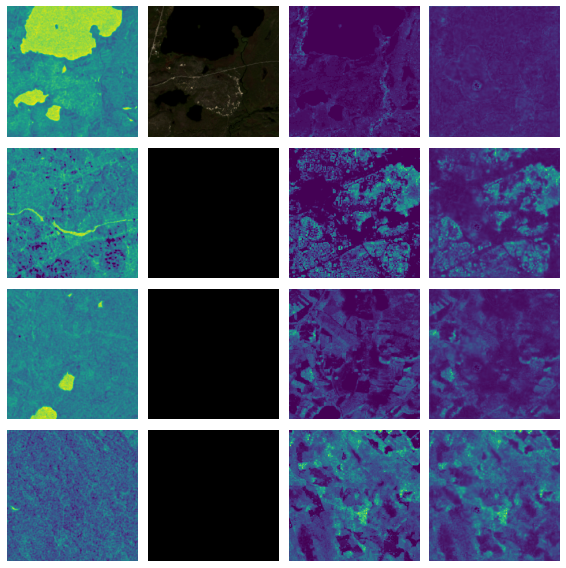

In [14]:
import matplotlib.pyplot as plt 

x, labels = next(iter(dm.train_dataloader(shuffle=False)))
s1s, s2s = x
preds = module.predict(x)
fig = plt.figure(figsize=(8, 2*dm.batch_size))
for i in range(dm.batch_size):
    ax = plt.subplot(dm.batch_size, 4, 4*i+1)
    ax.imshow(s1s[i][0][0])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+2)
    ax.imshow(s2s[i][0].permute(1, 2, 0))
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+3)
    ax.imshow(labels[i])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+4)
    ax.imshow(preds[i])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [15]:
from einops import rearrange

features = model.encoder1(rearrange(s1, 'b l c h w -> (b l) c h w'))

for f in features:
    f2 = rearrange(f, '(b l) c h w -> b l c h w', b=dm.batch_size)
    print(f.shape, f2.shape)

torch.Size([48, 2, 256, 256]) torch.Size([4, 12, 2, 256, 256])
torch.Size([48, 64, 128, 128]) torch.Size([4, 12, 64, 128, 128])
torch.Size([48, 64, 64, 64]) torch.Size([4, 12, 64, 64, 64])
torch.Size([48, 128, 32, 32]) torch.Size([4, 12, 128, 32, 32])
torch.Size([48, 256, 16, 16]) torch.Size([4, 12, 256, 16, 16])
torch.Size([48, 512, 8, 8]) torch.Size([4, 12, 512, 8, 8])


In [16]:
model.encoder1.out_channels

(2, 64, 64, 128, 256, 512)

In [29]:
from src.models.attention import PatchEmbedding

n_embed = 128

pes = [
    PatchEmbedding(256, 32, 2, n_embed),
    PatchEmbedding(128, 16, 64, n_embed),
    PatchEmbedding(64, 8, 64, n_embed),
    PatchEmbedding(32, 4, 128, n_embed),
    PatchEmbedding(16, 2, 256, n_embed),
    PatchEmbedding(8, 1, 512, n_embed)
]

for f, pe in zip(features, pes):
    fe = pe(f)
    f2 = rearrange(fe, '(b l) n e -> b (l n) e', b=dm.batch_size)
    print(f.shape, fe.shape, f2.shape)

torch.Size([48, 2, 256, 256]) torch.Size([48, 64, 128]) torch.Size([4, 768, 128])
torch.Size([48, 64, 128, 128]) torch.Size([48, 64, 128]) torch.Size([4, 768, 128])
torch.Size([48, 64, 64, 64]) torch.Size([48, 64, 128]) torch.Size([4, 768, 128])
torch.Size([48, 128, 32, 32]) torch.Size([48, 64, 128]) torch.Size([4, 768, 128])
torch.Size([48, 256, 16, 16]) torch.Size([48, 64, 128]) torch.Size([4, 768, 128])
torch.Size([48, 512, 8, 8]) torch.Size([48, 64, 128]) torch.Size([4, 768, 128])


In [37]:
from src.models.attention import Block 
import torch

attns = [
    Block(n_embed, n_embed, 1),
    Block(n_embed, n_embed, 1),
    Block(n_embed, n_embed, 1),
    Block(n_embed, n_embed, 1),
    Block(n_embed, n_embed, 1),
    Block(n_embed, n_embed, 1),
]

os = [
    torch.randn(1, 64, n_embed),
    torch.randn(1, 64, n_embed),
    torch.randn(1, 64, n_embed),
    torch.randn(1, 64, n_embed),
    torch.randn(1, 64, n_embed),
    torch.randn(1, 64, n_embed),
]

conv_ts = [
    torch.nn.ConvTranspose2d(n_embed, 2, 32, stride=32),
    torch.nn.ConvTranspose2d(n_embed, 64, 16, stride=16),
    torch.nn.ConvTranspose2d(n_embed, 64, 8, stride=8),
    torch.nn.ConvTranspose2d(n_embed, 128, 4, stride=4),
    torch.nn.ConvTranspose2d(n_embed, 256, 2, stride=2),
    torch.nn.ConvTranspose2d(n_embed, 512, 1, stride=1),
]

fos = []
for f, pe, attn, ct, o in zip(features, pes, attns, conv_ts, os):
    fe = rearrange(pe(f), '(b l) n e -> b (l n) e', b=dm.batch_size)
    q = o.repeat(dm.batch_size, 1, 1)
    print(fe.shape, q.shape)
    fa = attn(fe, q)
    fa = rearrange(fa, 'b n e -> b e n')
    fa = fa.view(dm.batch_size, n_embed, 8, 8)
    fo = ct(fa)
    print(f.shape, fe.shape, fa.shape, fo.shape)
    fos.append(fo)

torch.Size([4, 768, 128]) torch.Size([4, 64, 128])
torch.Size([48, 2, 256, 256]) torch.Size([4, 768, 128]) torch.Size([4, 128, 8, 8]) torch.Size([4, 2, 256, 256])
torch.Size([4, 768, 128]) torch.Size([4, 64, 128])
torch.Size([48, 64, 128, 128]) torch.Size([4, 768, 128]) torch.Size([4, 128, 8, 8]) torch.Size([4, 64, 128, 128])
torch.Size([4, 768, 128]) torch.Size([4, 64, 128])
torch.Size([48, 64, 64, 64]) torch.Size([4, 768, 128]) torch.Size([4, 128, 8, 8]) torch.Size([4, 64, 64, 64])
torch.Size([4, 768, 128]) torch.Size([4, 64, 128])
torch.Size([48, 128, 32, 32]) torch.Size([4, 768, 128]) torch.Size([4, 128, 8, 8]) torch.Size([4, 128, 32, 32])
torch.Size([4, 768, 128]) torch.Size([4, 64, 128])
torch.Size([48, 256, 16, 16]) torch.Size([4, 768, 128]) torch.Size([4, 128, 8, 8]) torch.Size([4, 256, 16, 16])
torch.Size([4, 768, 128]) torch.Size([4, 64, 128])
torch.Size([48, 512, 8, 8]) torch.Size([4, 768, 128]) torch.Size([4, 128, 8, 8]) torch.Size([4, 512, 8, 8])


In [ ]:
decoder_output = model.decoder(*fos)
print(decoder_output.shape)

outputs = model.segmentation_head(decoder_output)
print(outputs.shape)

torch.Size([4, 16, 256, 256])
torch.Size([4, 1, 256, 256])
